### Advanced topics of data analysis , Final report
### Mozhdeh Davoodifard

# **Elsdorf Landuse Scene Classification**

Elsdorf is a little town in the west part of Germany, near Cologne. The whole area is one of the largest lignite districts in Europe and the most important source of lignite within the country (95 Mt production/a). The study area is located near the former lignite mine of Bergheim, where the recultivation of the terrain was implemented, and finally completed in 2012 (Henselowsky et al., 2021). This particular area was chosen due to its history in which human has changed the the landuse not only through mining activities, but later in other relevant different ways as well. The main aim of this project is the masking of regions where land is being used in satellite images obtained through Landsat which have a low spatial resolution.

## Content
The Sentinel2 dataset contains satellite image of 7 classes such as Buildings, Railway, Forest, etc. The original size of the images is 801x707 pixels. 
For the 05_eurosat_rgb dataset originally there are 10000 images per class. It contains 10 classes such as AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, etc.

# 1. Packages and libraries

In [217]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
mpl.rcParams['figure.dpi']= 300
# this just tells Jupyter to plot inline
%matplotlib inline
from IPython.display import Image
from IPython.display import display
# plotting
import matplotlib.image as mpimg

import os

# utility
import rasterio
# import some modules
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import shapely
shapely.speedups.disable()

# utility
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold, train_test_split

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier


# models
#import tensorflow as tf
# tf.enable_eager_execution()  # uncomment for tf.__version__[0] < 2

In [2]:
# models
import tensorflow as tf

In [3]:
#tf.version.VERSION  #'2.6.0'

In [4]:
#!python --version #3.8.2

In [5]:
# pip install earthengine-api --upgrade

# 2. Import Google earth engine and Authenticate that
Google earth engine is a usefull tool in jupyter notebook to download prefered images of the area of the interest into the Google drive. For the first use only we need to authenticate that by loging into a google account. Google earth engine gives us the ability to have atmospheric correction in just a few  easy steps. 

In [6]:
# import and initialize Google Earth Engine

import ee
#ee.Authenticate()
ee.Initialize()

# 3. Collecting data from the area of the interest using desired satelite
In this section we need to define which type of data we need to download and where the area is.

In [7]:
# variable name for Sentinel 2 collection on Earth Engine
collection = 'COPERNICUS/S2'

# provide a short name for the area of interest
area_name = 'Elsdorf, Germany'

In this part we define the folder name in Google drive that images will be downloaded into it. We also need to give it the image's time range, Coordination, Bands to be downloded and resolution for the desired area. Here we also use max_cloud_percent = 1 in order to prevent downloading images with high atmospheric noises. 

In [8]:
# Spesify a name to the Google drive's folder for the image to be downloaded into it:
drive_folder = 'elsdorf_sentinel2_level1C'

# create a time range to look for images over, here the month of June in 2019:
time_range = ['2019-06-01', '2019-06-30']

# the maximum percentage of clouds we would like in the scene:
max_cloud_percent = 1

In [9]:
# selected bands for output raster:
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# spatial resolution for output raster in meters
# if not already at this resolution, then the selected bands will be resampled to it
spatial_resolution = 10

In [10]:
# bounding box coordinates in the format: xmin, ymin, xmax, ymax
bbox_coords = [6.556859,50.879311,6.665989,50.939463] # Elsdorf

In [11]:
# create a geometry object using the bounding box coordinates
AOI = ee.Geometry.Rectangle(bbox_coords)

# here we create an image collection, filtering by:
    # collection name, given by our 'collection' variable
    # area of interest, given by our 'AOI' variable
    # date range, given by our 'time_range' variable
    # maximum cloudiness, given by our 'max_cloud_percent' variable
image_collection = ee.ImageCollection(collection).\
                     filterBounds(AOI).\
                     filterDate(time_range[0], time_range[1]).\
                     filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))

# we only want one image from the selected time range, which we pick out here
first_img = image_collection.first()

In [12]:
# the image has metadata attached to it, let's have a quick look at that
first_img.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32631',
   'crs_transform': [60, 0, 699960, 0, -60, 5700000]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 699960, 0, -10, 5700000]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 699960, 0, -10, 5700000]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 699960, 0, -10, 5700000]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [13]:
# Here we need to define a name to the image, then we can download it to the Google drive.
# we get the output filename for the image using the product metadata
filename = 'EL19_' + first_img.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name + '_stacked_rescaled'
print(filename)

EL19_S2B_MSIL1C_20190627T104029_N0207_R008_T31UGS_20190627T125220_Elsdorf, Germany_stacked_rescaled


In [14]:
# now tell Earth Engine to create an export job to send a downloadable dataset to our Google Drive folder
export_job = ee.batch.Export.image.toDrive(
        first_img.select(band_list).divide(10000), # we export only the selected bands and rescale by 10000
        description=filename, # we provide the filename for the raster
        folder=drive_folder, # we provide the destination folder on our Google Drive
        region=AOI.getInfo()['coordinates'], # we provide the region of interest for clipping
        scale=spatial_resolution) # and finally we provide the output spatial resolution

# we have to actually start the job
export_job.start()

# and let's see if it's running
print('job status: {}'.format(export_job.status()['state']))

job status: READY


In [15]:
# variables for data filepaths:
# I already have the shapefile for the Elsdort area, located in the same folder:

sentinel_fp = 'EL19_S2B_MSIL1C_20190627T104029_N0207_R008_T31UGS_20190627T125220_Elsdorf, Germany_stacked_rescaled.tif'
label_fp = 'Elsdorf_2019.shp'

# variable with band list
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# variable with center wavelength for each band (in nanometers)
# see: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial
band_wavelengths = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]

In [16]:
# load the sentinel scene and print the metadata
full_dataset = rasterio.open(sentinel_fp)
print(full_dataset.meta)

# assign the number of bands to a variable
n_bands = full_dataset.count

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 801, 'height': 707, 'count': 10, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 749870.0,
       0.0, -10.0, 5649500.0)}


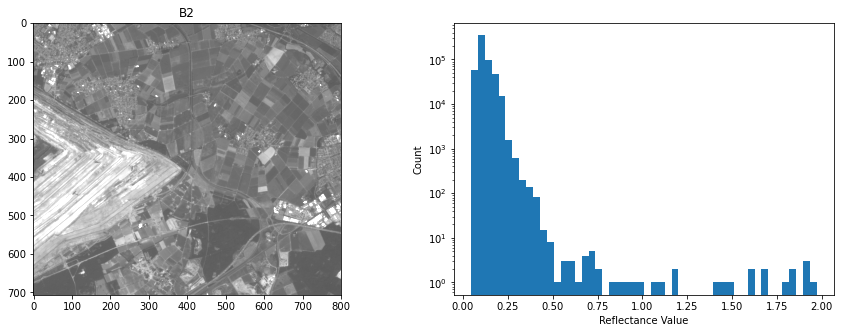

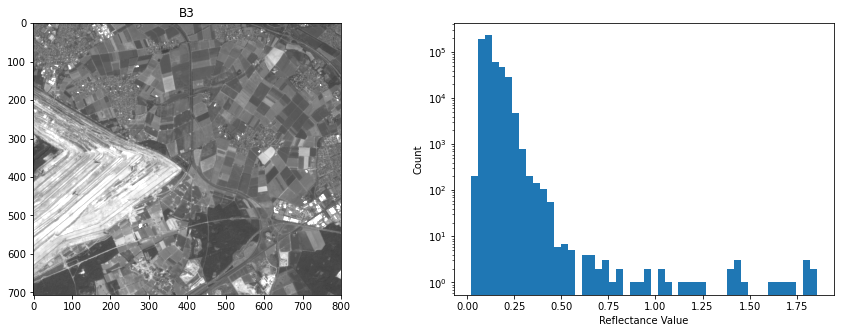

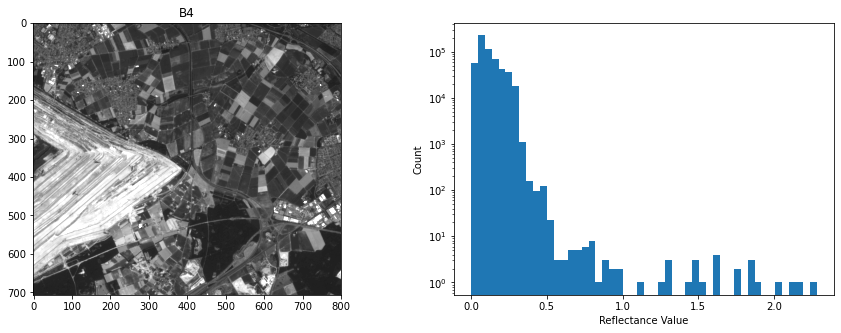

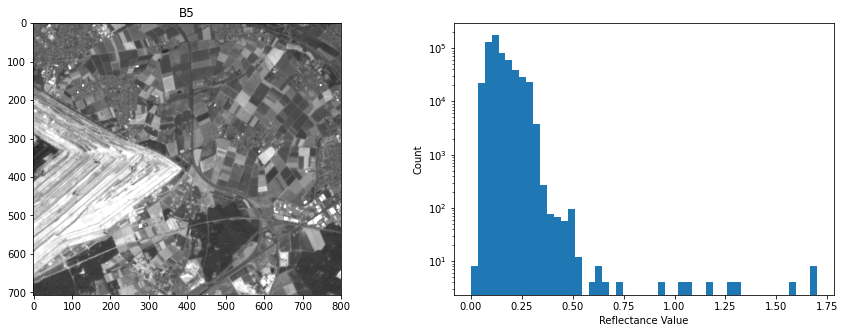

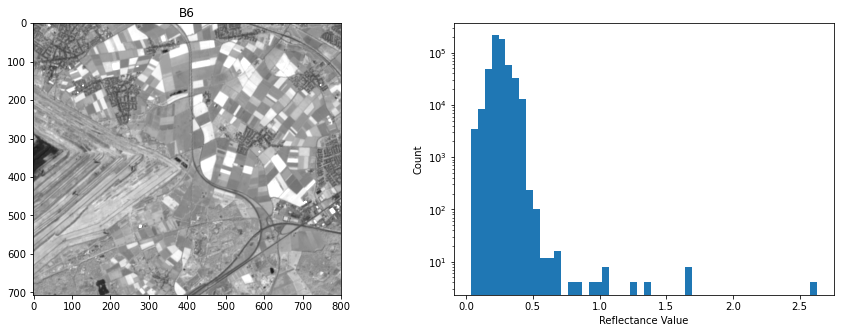

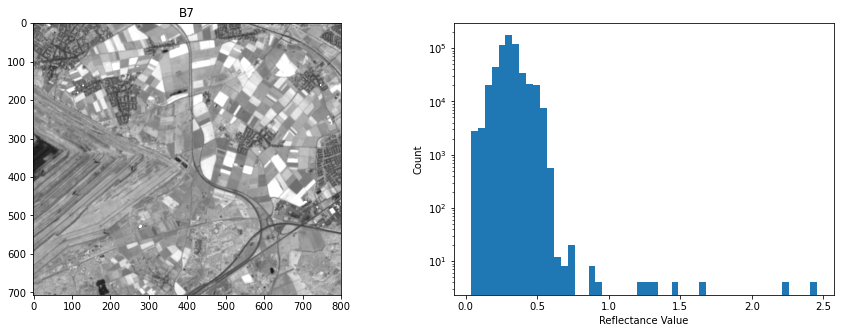

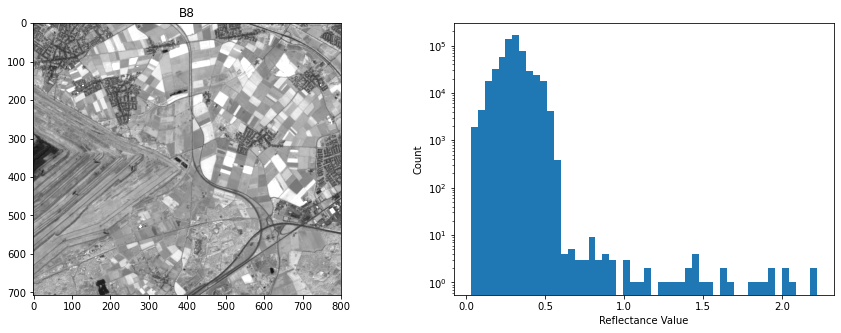

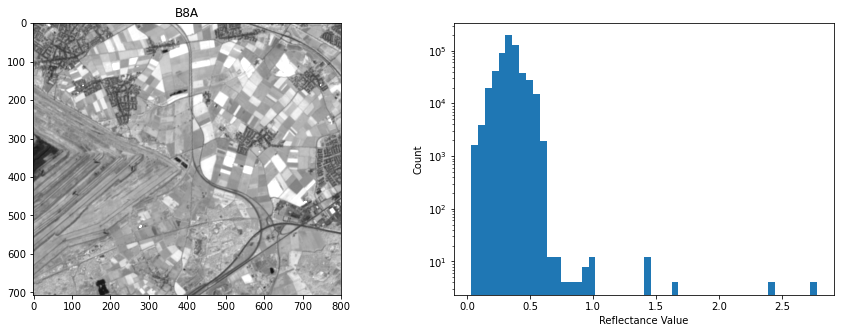

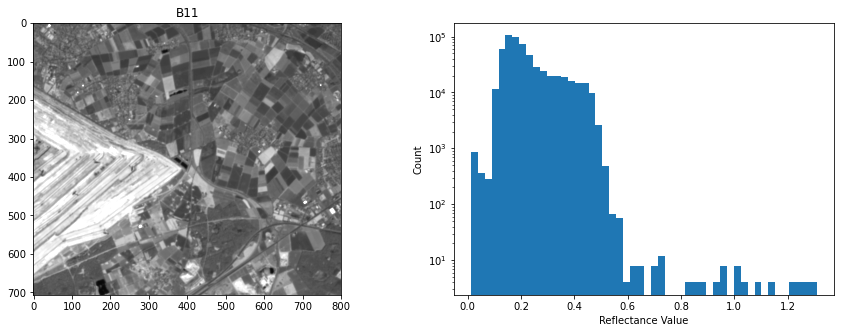

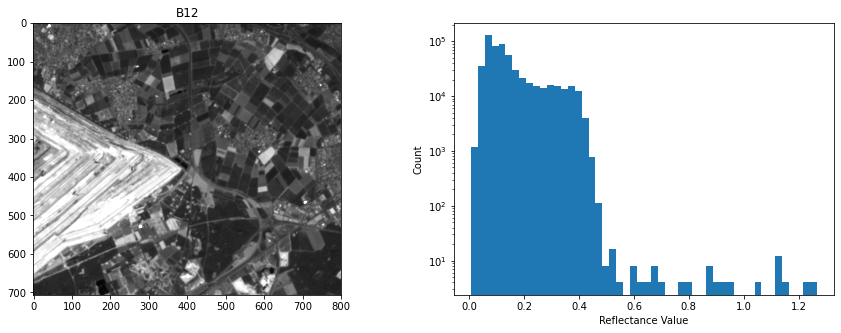

In [17]:
# We have downloded these 10 bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A','B11', 'B12'] 
# and here visualize them by reading in each raster band and display it and a histogram of the values:

for i in range(0, n_bands):
    img = full_dataset.read(i+1)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].imshow(img, vmin=0, vmax=np.percentile(img, 98), cmap='gray')
    ax[0].set_title(band_list[i])
    ax[1].hist(img.flatten(), bins=50)
    ax[1].set_yscale('log')
    ax[1].set_ylabel("Count")
    ax[1].set_xlabel("Reflectance Value")

In [18]:
# To have a look at the maximum value and upper percentile in the RGB bands we need to:

for band in [1, 2, 3]:
    img = full_dataset.read(band)
    print(band_list[band-1])
    print(img.max(), np.percentile(img, 99.9))
    print()
    
    # Here I faced high reflectances ( > 1), because the studied area, Elsdorf,
    #is congested with a very high density of buildings, roads and minig area.

B2
1.9721 0.305069397985937

B3
1.8569 0.3136693945527095

B4
2.2809 0.3488999903202057



In [19]:
# I need to show the raster ion RGB color, therfore:
# bands 3, 2, and 1 correspond to Sentinel-2 bands for red (Band 4), green (Band 3), and blue (Band 2), respectively
img = full_dataset.read([1,3,2])
print(img.shape)

# we need to move the band-depth axis to the last dimension for plotting
img = np.moveaxis(img, 0, -1)
print(img.shape)

(3, 707, 801)
(707, 801, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


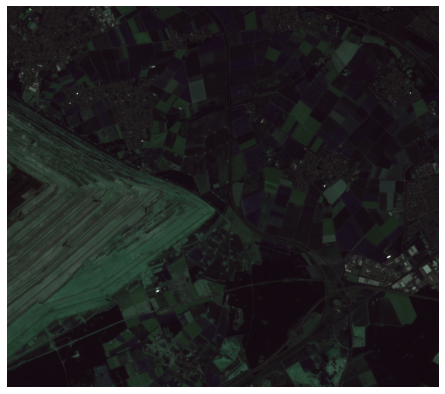

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(img)
ax.set_axis_off()

In [21]:
# here we rescale the range 0-0.275 in our first three bands to 8-bit 1-255
#(reserving 0 for no data) with the value of 0.355 I had a complete white image, 0.300
# was good enough, but 0.275 looks like the best.

#!gdal_translate -of JPEG -co QUALITY=100 \
 #   -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
  #  -b 3 -b 2 -b 1 -of JPEG \
   # EL19_S2B_MSIL1C_20190627T104029_N0207_R008_T31UGS_20190627T125220_Elsdorf, Germany_stacked_rescaled.tif \
   # Elsdorf_sentinel_2019_rgb_8bit_275.jpg

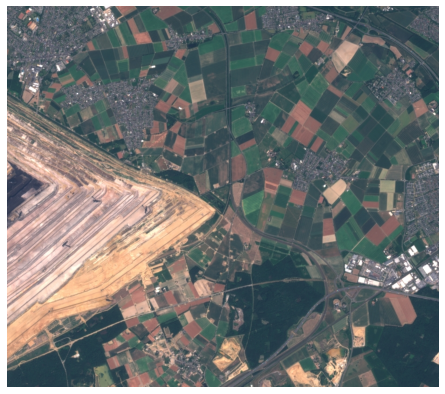

In [22]:
# load image of Elsdorf, date 2019, range 275:

rgb_fp = 'Elsdorf_sentinel_2019_rgb_8bit_275.jpg'
img = mpimg.imread(rgb_fp)

fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(img)
ax.set_axis_off()

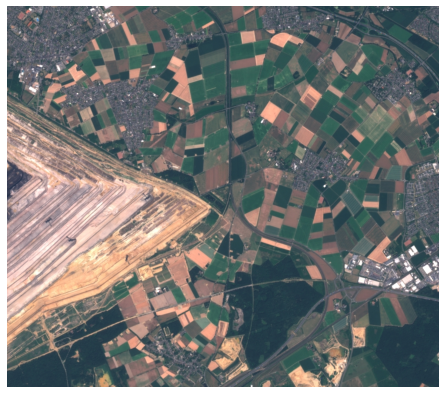

In [23]:
# load image of Elsdorf, date 2018, range 275:

rgb_fp = 'Elsdorf18_sentinel_2018_rgb_8bit_275.jpg'
img = mpimg.imread(rgb_fp)

fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(img)
ax.set_axis_off()

# 4. Load the data
After all these steps the data is ready to use. We make a path to the original tiff and the RGB image we generate to be compared with the predicted classes in the following steps.

In [24]:
# file path to the rgb image for visualization:
rgb_fp = 'Elsdorf_sentinel_2019_rgb_8bit_275.jpg'

# load original tiff file:
sentinel_fp = 'EL19_S2B_MSIL1C_20190627T104029_N0207_R008_T31UGS_20190627T125220_Elsdorf, Germany_stacked_rescaled.tif'
full_dataset = rasterio.open(sentinel_fp)
print(full_dataset.meta)

# save width and height for later reshaping:
width = full_dataset.meta['width']
height = full_dataset.meta['height']

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 801, 'height': 707, 'count': 10, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 749870.0,
       0.0, -10.0, 5649500.0)}


# 5. Load the Labels

#### Before train the data we need to check the labels, how many labels there is and to change the projection system. 

In [25]:
# first check the projection of the Sentinel data
project_to = full_dataset.crs.to_dict()['init']
print(project_to)

epsg:32631


The projection of the desired sentinental image is 32631, we need to use the shapefile of the same area because we need the lables for the landuse, as a result the projection of the image should be the same as shapefile.

In [26]:
# Shapefile can be loaded using pandas, the only thing is to check the projection of it:

shapefile = gpd.read_file(label_fp)
print(shapefile.head())

# To see how many labels there are:
print('\nthere are {} labels'.format(len(shapefile)))
# To see how what the labels are:
print('\nthe labels are {}'.format(np.unique(shapefile.Classes)))


# To check the projection of the shapefile with the sentinel image(espg:32631):
shapefile = shapefile.to_crs(project_to)
print('projection is now: {}'.format(shapefile.crs))

   id  Classes                                           geometry
0   1  Railway  POLYGON ((6.61370 50.91660, 6.61402 50.91651, ...
1   2  Railway  POLYGON ((6.62341 50.90226, 6.62582 50.90164, ...
2   3  Railway  POLYGON ((6.62551 50.88281, 6.62949 50.88413, ...
3   4     Road  POLYGON ((6.63482 50.89093, 6.63529 50.89064, ...
4   5     Road  POLYGON ((6.65709 50.89199, 6.66039 50.89154, ...

there are 16 labels

the labels are ['Buildings' 'Dirt' 'Farm' 'Forest' 'Mine' 'Railway' 'Road']
projection is now: epsg:32631


current polygon is of class: Railway

vertices of the current polygon are: POLYGON ((755006.3816499371 5643056.603454215, 755279.0655494295 5643216.789960194, 755301.0759090297 5643169.100847728, 755036.9515938265 5643000.35475746, 755006.3816499371 5643056.603454215))

and this shape looks like:


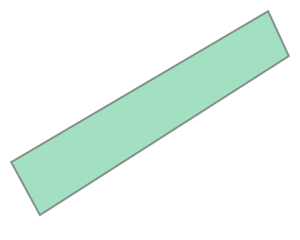

In [27]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# to show you what this looks like let's grab a random polygon in the shapefile
geometry = geoms[2] 
classname = shapefile['Classes'][2]
print('current polygon is of class: {}'.format(classname))
print('\nvertices of the current polygon are: {}'.format(geometry))
print('\nand this shape looks like:')
geometry

Masked area shape is: (10, 22, 31)

So this clip (with class Railway) is a 22 by 31 pixel stack of the 10 Sentinel bands.

And the first band looks like so:


Text(0.5, 1.0, 'B2')

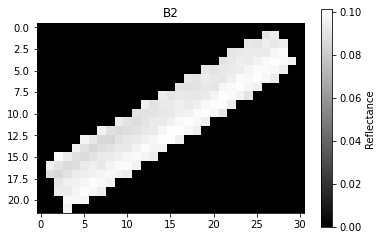

In [28]:
# check the shape of a dataset is the way to check its dimension.
# To plot a shapefile we need to change it to a Geojson format which is simply done here.

# transform to GeoJSON format using rasterio 'mapping' function
feature = [mapping(geometry)]

# By using a mask, the pixel values are finaly pulled out:
out_image = mask(full_dataset, feature, crop=True, filled=True)[0]
print('Masked area shape is: {}'.format(out_image.shape))

print('\nSo this clip (with class {}) is a {} by {} pixel stack of the {} Sentinel bands.'
      .format(classname, out_image.shape[1], out_image.shape[2], out_image.shape[0]))

print('\nAnd the first band looks like so:')

# Plot the shapefile inGeojson format to see how it looks like and what is the dimension:
fig, ax = plt.subplots(1,1)
im = ax.imshow(out_image[0], cmap='gray')
fig.colorbar(im, ax=ax, label='Reflectance')
ax.set_title('{}'.format(band_list[0]))

---
The aim of this study is to do a proper classification on the landuse at Elsdorf. Before any more steps we need to train some data and lables to use in this classification. More details will be provided in the following cells.

# 6. Prepare training samples

In [29]:
# we need to pick up pixels for training, actually we train data to be used for modeling:
X = np.array([], dtype=np.float32).reshape(n_bands, -1)

# Beside the pixels we also pick up labels for train data:
y = np.array([], dtype=np.string_)

# In the folowing steps we see what labels are traind for classification.

In [30]:
# looping over geometries
for index, geom in enumerate(geoms):
    # get the current polygon
    feature = [mapping(geom)]
    # get the classname for the polygon
    classname = shapefile['Classes'][index]
    # the mask function returns an array of the raster pixels within this polygon
    out_image = mask(full_dataset, feature, nodata=0, crop=True)[0]
    # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
    out_image = out_image[:, ~np.all(out_image == 0, axis=0)]
    # append the labels to the y array
    y = np.append(y, [classname] * out_image.shape[1]) 
    # stack the pixels onto the pixel array
    X = np.hstack((X, out_image))

In [31]:
# What are our classification labels?
labels = np.unique(shapefile["Classes"])
print('The training data include {} classes: {}\n'.format(labels.size, labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {}'.format(X.shape))
print('Our y array is sized: {}'.format(y.shape))

The training data include 7 classes: ['Buildings' 'Dirt' 'Farm' 'Forest' 'Mine' 'Railway' 'Road']

Our X matrix is sized: (10, 117709)
Our y array is sized: (117709,)


---
In the folowing steps we try to investigate our data in order to model it. Each model has its own algorithm and result in a different accuracy percentage. We will check as more models as possible to choose the best and highest accuracy for our data. Here we do not aim into calculate the recall.
Totrally said, there are 6 ways to increase the accuracy of the models as it is shown in the figure below:

<img src='Capture.jpg' width="500" height="400">

First we explore the quality of data, then we will compare different Algorithms to choose the best and highest accuracy.

## Explore the Spectral Signatures

A spectral signature is a plot of the amount of light energy reflected by an object throughout the range of wavelengths in the electromagnetic spectrum. The spectral signature of an object conveys useful information about its structural and chemical composition. We can use these signatures to identify and classify different objects from a spectral image.

As an example, vegetation has a unique spectral signature characterized by high reflectance in the near infrared wavelengths, and much lower reflectance in the green portion of the visible spectrum. We can extract reflectance values in the NIR and visible spectrums from hyperspectral data in order to map vegetation on the earth's surface.

Runing the cell below, and gain a better sense of what the spectra look like for different materials on the ground.

Text(0.5, 1.0, 'Reflectance versus Band Wavelength in nanometers')

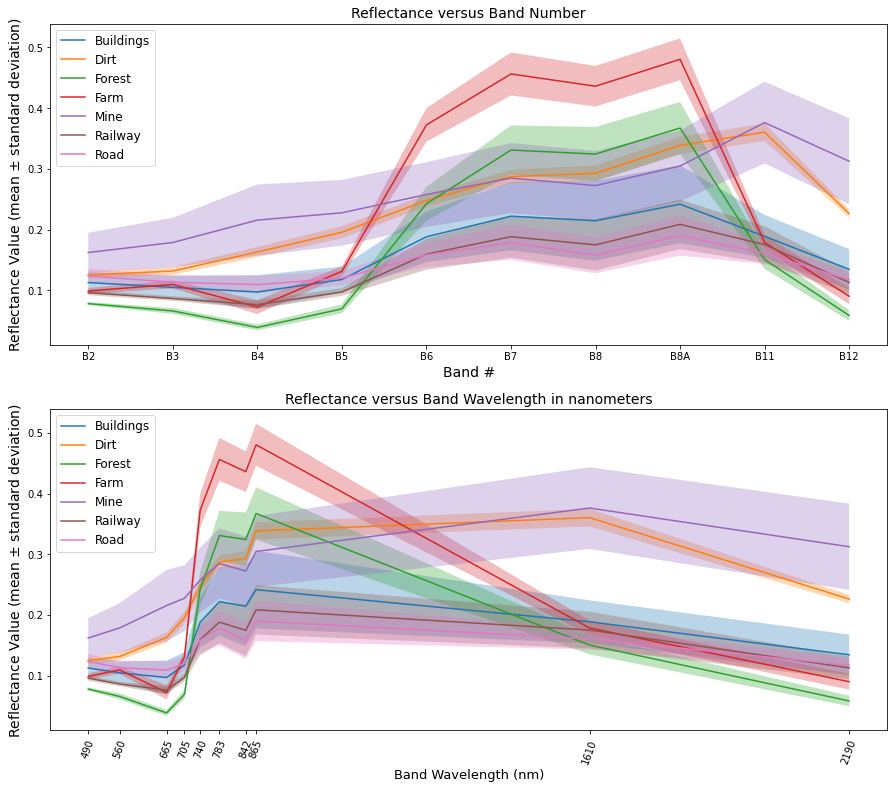

In [32]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

all_labels = ['Buildings','Dirt','Forest','Farm',
              'Mine','Railway','Road']

labels_to_plot = ['Buildings','Dirt','Forest','Farm',
              'Mine','Railway','Road']

# loop through classes and plot the mean in each band
bands = range(1, n_bands+1)
for label in labels_to_plot:
    mean = np.mean(X[:, y==label], axis=1)
    std = np.std(X[:, y==label], axis=1)
    axs[0].fill_between(bands, mean-std, mean+std, alpha=0.3)
    axs[0].plot(bands, mean, label=label)
    axs[1].fill_between(band_wavelengths, mean-std, mean+std, alpha=0.3)
    axs[1].plot(band_wavelengths, mean, label=label)
axs[0].set_xticks(bands)
axs[0].set_xticklabels(band_list)
axs[0].set_xlabel('Band #', fontsize=14)
axs[0].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].set_title('Reflectance versus Band Number', fontsize=14)
axs[1].set_xticks(band_wavelengths)
axs[1].tick_params('x', labelrotation=70)
axs[1].set_xlabel('Band Wavelength (nm)', fontsize=13)
axs[1].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].set_title('Reflectance versus Band Wavelength in nanometers', fontsize=14)

In order to do a classification on our data, we first need to prepare our data to predict a supervised model here. Preparing of the data starts with reshaping the trained data:

## Reshaping data

In [33]:
# We need to transpose X (trained pixels) to have features as columns:
X_reshape = X.T
print('X.shape is:', X.shape)
print('X.reshaped is:', X_reshape.shape)

X.shape is: (10, 117709)
X.reshaped is: (117709, 10)


In [34]:
# save the pixel values and the class of each pixel:
with open('Elsdorf_pixel_bands.npy', 'wb') as f:
    np.save(f, X_reshape)

with open('Elsdorf_pixel_band_classes.npy', 'wb') as f:
    np.save(f, y)

## Load and Inspect Data

In [35]:
# load training data
X = np.load('Elsdorf_pixel_bands.npy')
y = np.load('Elsdorf_pixel_band_classes.npy')

# load prediction image
X_pred = full_dataset.read()
print(X_pred.shape)

# adjust the axis to move band axis to the last dimension
X_pred = np.moveaxis(X_pred, 0, -1)
print(X_pred.shape)

# finally reshape to create array of pixels and values
X_pred = X_pred.reshape(-1, full_dataset.meta['count'])
print(X_pred.shape)

(10, 707, 801)
(707, 801, 10)
(566307, 10)


In [36]:
# parameters
reduce_bands = True

In [37]:
# shuffle X, y
rp = np.random.permutation(len(X))
X = X[rp]
y = y[rp]

In [38]:
print(X.shape, X_pred.shape, y.shape)

(117709, 10) (566307, 10) (117709,)


In [39]:
print(X.dtype, X_pred.dtype, y.dtype)

float32 float32 <U9


In [40]:
print(y)

['Mine' 'Mine' 'Mine' ... 'Buildings' 'Buildings' 'Mine']


In [41]:
print(X.mean(axis=0))
print(X.std(axis=0))

[0.15207459 0.16482396 0.19300851 0.20783684 0.25311008 0.28494278
 0.27325433 0.30586997 0.3440513  0.27891698]
[0.03827695 0.04939247 0.07519152 0.06783313 0.05775524 0.06574298
 0.06548762 0.0678989  0.09668174 0.10125105]


In [42]:
# show label counts
df = pd.DataFrame(X)
df['label'] = y
df.label.value_counts()

Mine         98166
Buildings    10343
Forest        5413
Farm          2686
Dirt           678
Railway        291
Road           132
Name: label, dtype: int64

In [43]:
# reduce bands to 4: In the next steps we will compare the result of 4bands and 10 bands
if reduce_bands:
    X = X[:, [0,1,2,6]]
    X_pred = X_pred[:, [0,1,2,6]]

# 7. Preprocessing

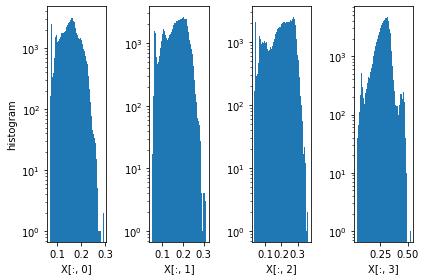

In [44]:
# plot density of data point for each dimension to see if there are outliers
if reduce_bands:
    fig, axs = plt.subplots(1, 4)
else:
    fig, axs = plt.subplots(2, 5)
axs = axs.flatten()
    
axs[0].set_ylabel('histogram')
for i, ax in enumerate(axs):
    ax.hist(X[:, i], bins=100)
    ax.set_xlabel('X[:, {}]'.format(i))
    ax.set_yscale('log')
fig.tight_layout()

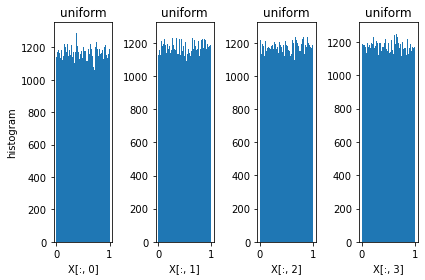

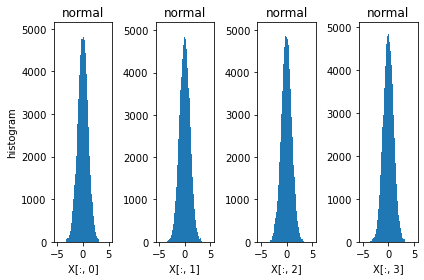

In [45]:
# try QuantileTransformer
for output_distribution in ['uniform', 'normal']:
    
    X_ = QuantileTransformer(output_distribution=output_distribution).fit_transform(X)

    if reduce_bands:
        fig, axs = plt.subplots(1, 4)
    else:
        fig, axs = plt.subplots(2, 5)
    axs = axs.flatten()

    axs[0].set_ylabel('histogram')
    for i, ax in enumerate(axs.flatten()):
        ax.hist(X_[:, i], bins=100)
        ax.set_title(output_distribution)
        ax.set_xlabel('X[:, {}]'.format(i))
        # ax.set_yscale('log')
    fig.tight_layout()

# 8. Models application
Compare Accuracy of different models for classification


In [46]:
# define function to validate models
def evaluate_model(clf, cv):

    # train model
    clf.fit(X, y)

    # compute cross-validation score
    scores = cross_val_score(clf, X, y, cv=cv)

    # compute mean score and 95% confidence interval of the score estimate
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

    # return to keep track
    return clf, scores.mean(), scores.std()*2    

In [47]:
# keep track of scores for different models, to compare the result at the end
names = []
clfs = []
scores = []
scores_std = []

## Perceptron

### no preprocessing, default settings

In [48]:
%%time
# 1min #Accuracy: 0.8936 (+/- 0.0829)
# classifier
clf = Perceptron()

# evaluate
cv = StratifiedShuffleSplit(n_splits=100)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('Perceptron_np_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.8912 (+/- 0.0712)
Wall time: 36 s


### standard scaler, default settings

In [49]:
%%time
# 1min 9s #Accuracy: 0.8978 (+/- 0.0385)
# classifier
clf = make_pipeline(StandardScaler(), Perceptron())

# evaluate
cv = StratifiedShuffleSplit(n_splits=100)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('Perceptron_StandardScaler_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9021 (+/- 0.0307)
Wall time: 27 s


### quantile transformer (normal), default settings

In [50]:
%%time
# 39.7 s #Accuracy: 0.8880 (+/- 0.0417)
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=50, output_distribution='normal'), Perceptron())

# evaluate
cv = StratifiedShuffleSplit(n_splits=100)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('Perceptron_QT_normal_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.8884 (+/- 0.0386)
Wall time: 38.9 s


### quantile transformer (uniform), default settings

In [51]:
%%time
# 1min 15s #Accuracy: 0.8846 (+/- 0.0445)
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=50, output_distribution='uniform'), Perceptron())

# evaluate
cv = StratifiedShuffleSplit(n_splits=100)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('Perceptron_QT_uniform_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.8879 (+/- 0.0545)
Wall time: 28.1 s


### quantile transformer (uniform), polynomial degree

In [52]:
%%time
# Accuracy: 0.9425 (+/- 0.0181), Wall time: 16min 11s

if reduce_bands:
    
    # classifier
    clf = make_pipeline(
        QuantileTransformer(n_quantiles=50, output_distribution='uniform'), 
        PolynomialFeatures(),
        Perceptron()
    )

    # perform grid search to find optimal polynomial degree
    param_grid = {'polynomialfeatures__degree': range(1, 11)}
    clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, refit=True)

    # evaluate
    cv = StratifiedKFold(n_splits=5)
    clf, score, score_std = evaluate_model(clf, cv)

    # keep track of results
    names.append('Perceptron_QT_uniform_polynomial')
    clfs.append(clf)
    scores.append(score)
    scores_std.append(score_std)

    # show results
    cv_results = pd.DataFrame(clf.cv_results_)
    cv_results

Accuracy: 0.9425 (+/- 0.0181)
Wall time: 16min 11s


## Random Forest

### quantile transformer (uniform), default settings

In [53]:
%%time
# 2min 23s #Accuracy: 0.9687 (+/- 0.0023)
# classifier
clf = make_pipeline(
    QuantileTransformer(n_quantiles=50, output_distribution='uniform'), 
    RandomForestClassifier()
)

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('RFC_QT_uniform_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9697 (+/- 0.0024)
Wall time: 58.4 s


## KNN Classifier

### standard scaler, deafult settings

In [54]:
%%time
# Accuracy: 0.9663 (+/- 0.0031), Wall time: 4min 11s
# classifier
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('KNN_StandardScaler_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9663 (+/- 0.0031)
Wall time: 4min 11s


### quantile transformer (normal), deafult settings

In [55]:
%%time
# 5Accuracy: 0.9659 (+/- 0.0029), Wall time: 4min 55s
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=50, output_distribution='normal'), KNeighborsClassifier())

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('KNN_QT_normal_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9659 (+/- 0.0029)
Wall time: 4min 55s


### quantile transformer (uniform), default settings

In [56]:
%%time
# Accuracy: 0.9656 (+/- 0.0032), Wall time: 4min 34s
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=50, output_distribution='uniform'), KNeighborsClassifier())

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('KNN_QT_uniform_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9656 (+/- 0.0032)
Wall time: 4min 34s


## SVM

### standard scaler, default settings

In [57]:
%%time
# 1min 50s , Accuracy: 0.9653 (+/- 0.0006)
# classifier
clf = make_pipeline(StandardScaler(), SVC())

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('SVM_StandardScaler_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9653 (+/- 0.0006)
Wall time: 2min 29s


### quantile transformer (normal), default settings

In [63]:
%%time
# 1min, Accuracy: 0.9630 (+/- 0.0024)
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=5, output_distribution='normal'), SVC())

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('SVM_QT_normal_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9630 (+/- 0.0024)
Wall time: 2min 57s


### quantile transformer (uniform), default settings

In [59]:
%%time
# 3min 58s, Accuracy: 0.9602 (+/- 0.0035)
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=50, output_distribution='uniform'), SVC())

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('SVM_QT_uniform_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9602 (+/- 0.0035)
Wall time: 3min 21s


## ANN

### standard scaler, default settings

In [64]:
%%time
# Accuracy: 0.9664 (+/- 0.0029), Wall time: 8min 51s
# classifier
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs'))

# evaluate
# cv = StratifiedKFold(n_splits=10)
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('ANN_StandardScaler_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9664 (+/- 0.0029)
Wall time: 8min 51s


### quantile transfomer (normal), default settings

In [65]:
%%time
# Accuracy: 0.9668 (+/- 0.0014), Wall time: 6min 26s
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=3, output_distribution='normal'), 
                    MLPClassifier(solver='lbfgs'))

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('ANN_QT_normal_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9668 (+/- 0.0014)
Wall time: 6min 26s


### quantile transformer (uniform), default settings

In [66]:
%%time
# Accuracy: 0.9616 (+/- 0.0027), Wall time: 6min 19s
# classifier
clf = make_pipeline(QuantileTransformer(n_quantiles=3, output_distribution='uniform'), 
                    MLPClassifier(solver='lbfgs'))

# evaluate
cv = StratifiedShuffleSplit(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('ANN_QT_uniform_default')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

Accuracy: 0.9616 (+/- 0.0027)
Wall time: 6min 19s


### standard scaler, alpha

In [67]:
%%time
# Accuracy: 0.9207 (+/- 0.0117), Wall time: 5min 59s
# classifier
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs', max_iter=10))

# perform grid search to find optimal polynomial degree
param_grid = {'mlpclassifier__alpha': 10.0 ** -np.arange(1, 6)}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, refit=True)

# evaluate
cv = StratifiedKFold(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('ANN_StandardScaler_alpha')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

# show results
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

Accuracy: 0.9207 (+/- 0.0117)
Wall time: 5min 59s


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.869467      0.243088         0.065022        0.006891   
1       4.533753      0.155201         0.068954        0.005682   
2       4.457822      0.036911         0.064032        0.007520   
3       4.441897      0.028127         0.063386        0.001719   
4       4.484387      0.024125         0.067403        0.005731   

  param_mlpclassifier__alpha                            params  \
0                        0.1     {'mlpclassifier__alpha': 0.1}   
1                       0.01    {'mlpclassifier__alpha': 0.01}   
2                      0.001   {'mlpclassifier__alpha': 0.001}   
3                     0.0001  {'mlpclassifier__alpha': 0.0001}   
4                      1e-05   {'mlpclassifier__alpha': 1e-05}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.912922           0.915555           0.908249           0.917637   
1           0.909991           0.932546           0.928213           0.915173   
2           0.906295           0.925240           0.940234           0.911817   
3           0.917424           0.908249           0.916702           0.923753   
4           0.911350           0.911605           0.911647           0.907824   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.921541         0.915181        0.004467                4  
1           0.928210         0.922827        0.008670                1  
2           0.915127         0.919743        0.011959                2  
3           0.914447         0.916115        0.005001                3  
4           0.902383         0.908962        0.003591                5

### standard scaler, layers

In [68]:
%%time
# Accuracy: 0.8835 (+/- 0.0106), Wall time: 1min 56s
# classifier
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs', alpha=.1, max_iter=5))

# perform grid search to find optimal polynomial degree
param_grid = {'mlpclassifier__hidden_layer_sizes': [(50, ), (50, 50, ), (30, 30, 30)]}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, refit=True)

# evaluate
cv = StratifiedKFold(n_splits=3)
clf, score, score_std = evaluate_model(clf, cv)

# keep track of results
names.append('ANN_StandardScaler_layers')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

# show results
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

Accuracy: 0.8835 (+/- 0.0106)
Wall time: 1min 56s


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.515677      0.087282         0.034932        0.004554   
1       2.963765      0.024873         0.067840        0.009008   
2       2.827634      0.014843         0.056388        0.007782   

  param_mlpclassifier__hidden_layer_sizes  \
0                                   (50,)   
1                                (50, 50)   
2                            (30, 30, 30)   

                                              params  split0_test_score  \
0       {'mlpclassifier__hidden_layer_sizes': (50,)}           0.870487   
1    {'mlpclassifier__hidden_layer_sizes': (50, 50)}           0.888370   
2  {'mlpclassifier__hidden_layer_sizes': (30, 30,...           0.834721   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.883442           0.893934           0.873418           0.892018   
1           0.865262           0.870062           0.859273           0.873030   
2           0.833956           0.839224           0.812845           0.833992   

   mean_test_score  std_test_score  rank_test_score  
0         0.882660        0.009475                1  
1         0.871199        0.009767                2  
2         0.830948        0.009260                3

# 9. Models Results
You can see the result of all models run on this study in the table bellow. 
As it is shown, almost all the models provided a score higher that 90% but 
Random Forest Model  has the highest accuracy of all.

In [85]:
# Result:

res = pd.DataFrame(index=names, data={'clf': clfs, 'score': scores,
            'score_std': scores_std}).sort_values(by=['score', 'score_std'], ascending=False)
res

clf  \
RFC_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
ANN_QT_normal_default              (QuantileTransformer(copy=True, ignore_implici...   
ANN_StandardScaler_default         (StandardScaler(copy=True, with_mean=True, wit...   
KNN_StandardScaler_default         (StandardScaler(copy=True, with_mean=True, wit...   
KNN_QT_normal_default              (QuantileTransformer(copy=True, ignore_implici...   
KNN_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
SVM_StandardScaler_default         (StandardScaler(copy=True, with_mean=True, wit...   
SVM_QT_normal_default              (QuantileTransformer(copy=True, ignore_implici...   
ANN_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
SVM_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
Perceptron_QT_uniform_polynomial   GridSearchCV(cv=5, error_score=nan,\n         ...   
ANN_StandardScaler_alpha           GridSearchCV(cv=5, error_score=nan,\n         ...   
Perceptron_StandardScaler_default  (StandardScaler(copy=True, with_mean=True, wit...   
Perceptron_np_default              Perceptron(alpha=0.0001, class_weight=None, ea...   
Perceptron_QT_normal_default       (QuantileTransformer(copy=True, ignore_implici...   
Perceptron_QT_uniform_default      (QuantileTransformer(copy=True, ignore_implici...   
ANN_StandardScaler_layers          GridSearchCV(cv=5, error_score=nan,\n         ...   

                                      score  score_std  
RFC_QT_uniform_default             0.969728   0.002444  
ANN_QT_normal_default              0.966811   0.001417  
ANN_StandardScaler_default         0.966386   0.002885  
KNN_StandardScaler_default         0.966324   0.003079  
KNN_QT_normal_default              0.965859   0.002911  
KNN_QT_uniform_default             0.965558   0.003179  
SVM_StandardScaler_default         0.965282   0.000561  
SVM_QT_normal_default              0.962960   0.002407  
ANN_QT_uniform_default             0.961629   0.002720  
SVM_QT_uniform_default             0.960213   0.003483  
Perceptron_QT_uniform_polynomial   0.942494   0.018089  
ANN_StandardScaler_alpha           0.920745   0.011676  
Perceptron_StandardScaler_default  0.902078   0.030705  
Perceptron_np_default              0.891232   0.071161  
Perceptron_QT_normal_default       0.888439   0.038629  
Perceptron_QT_uniform_default      0.887916   0.054508  
ANN_StandardScaler_layers          0.883535   0.010647

# Save the result for 4-band Classification

In [86]:
# Need to store results for classification:

if reduce_bands:
    nbands = 4
else:
    nbands = 10

res.to_pickle('Elsdorf19_model_results_{}_bands.pkl'.format(nbands))

In [95]:
res_4 = pd.read_pickle('Elsdorf19_model_results_4_bands.pkl')
res_4.sort_values(by=['score', 'score_std'], ascending=False)


clf  \
RFC_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
ANN_QT_normal_default              (QuantileTransformer(copy=True, ignore_implici...   
ANN_StandardScaler_default         (StandardScaler(copy=True, with_mean=True, wit...   
KNN_StandardScaler_default         (StandardScaler(copy=True, with_mean=True, wit...   
KNN_QT_normal_default              (QuantileTransformer(copy=True, ignore_implici...   
KNN_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
SVM_StandardScaler_default         (StandardScaler(copy=True, with_mean=True, wit...   
SVM_QT_normal_default              (QuantileTransformer(copy=True, ignore_implici...   
ANN_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
SVM_QT_uniform_default             (QuantileTransformer(copy=True, ignore_implici...   
Perceptron_QT_uniform_polynomial   GridSearchCV(cv=5, error_score=nan,\n         ...   
ANN_StandardScaler_alpha           GridSearchCV(cv=5, error_score=nan,\n         ...   
Perceptron_StandardScaler_default  (StandardScaler(copy=True, with_mean=True, wit...   
Perceptron_np_default              Perceptron(alpha=0.0001, class_weight=None, ea...   
Perceptron_QT_normal_default       (QuantileTransformer(copy=True, ignore_implici...   
Perceptron_QT_uniform_default      (QuantileTransformer(copy=True, ignore_implici...   
ANN_StandardScaler_layers          GridSearchCV(cv=5, error_score=nan,\n         ...   

                                      score  score_std  
RFC_QT_uniform_default             0.969728   0.002444  
ANN_QT_normal_default              0.966811   0.001417  
ANN_StandardScaler_default         0.966386   0.002885  
KNN_StandardScaler_default         0.966324   0.003079  
KNN_QT_normal_default              0.965859   0.002911  
KNN_QT_uniform_default             0.965558   0.003179  
SVM_StandardScaler_default         0.965282   0.000561  
SVM_QT_normal_default              0.962960   0.002407  
ANN_QT_uniform_default             0.961629   0.002720  
SVM_QT_uniform_default             0.960213   0.003483  
Perceptron_QT_uniform_polynomial   0.942494   0.018089  
ANN_StandardScaler_alpha           0.920745   0.011676  
Perceptron_StandardScaler_default  0.902078   0.030705  
Perceptron_np_default              0.891232   0.071161  
Perceptron_QT_normal_default       0.888439   0.038629  
Perceptron_QT_uniform_default      0.887916   0.054508  
ANN_StandardScaler_layers          0.883535   0.010647

In [88]:
res_4.shape

(17, 3)


# 10. Plot predicted classes

Now that we have our supervised model, let's predict on the every pixel in the image!
According to the previouse step, Random Forest model has the highest score and we use it here to predict classes. 

In [96]:
# which model do we want to check? select by score!
#clf = res.loc[res['score'] == res['score'].max(), 'clf'].values[0]
# classifier name
#classifier_name = res.loc[res['score'] == res['score'].max(), 'clf'].index.values[0]

In [97]:
# Run the prediction on the full, reshaped image. Then reshape it back to the original shape:

# original shape of scene
orig_shape = (height, width)

# run prediction on the image
y_pred = clf.predict(X_pred)

# reshape y back to a 2D matrix for visualization
y_pred_img = y_pred.reshape(orig_shape)

In [99]:
# reclassify the string label names as numeric values cause
# we need integer values to plot the results therefore we 
# change type  of the labels from str to int first:

labels = ['Buildings', 'Dirt', 'Farm', 'Forest', 'Mine', 'Railway', 'Road']

for i, label in enumerate(labels):
    y_pred_img[y_pred_img == label] = i
y_pred_img = y_pred_img.astype(int)

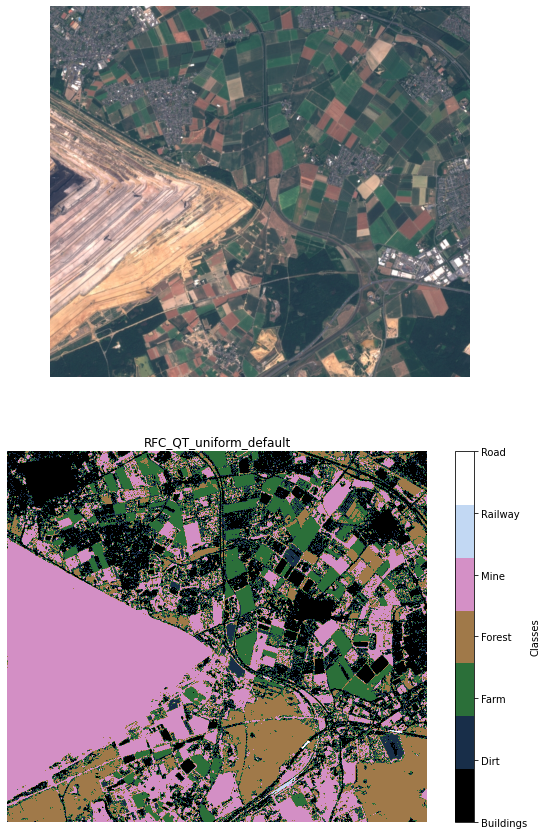

In [100]:
# plot the results, the original image and predicted labels by Random Forest modeling:

img = mpimg.imread(rgb_fp)

fig, axs = plt.subplots(2,1,figsize=(10,15))

axs[0].imshow(img)
axs[0].set_axis_off()

predict_plot = axs[1].imshow(y_pred_img, cmap=plt.cm.get_cmap('cubehelix', len(labels)))
cbar = fig.colorbar(predict_plot, ax=axs[1], label='Classes')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
axs[1].set_title(classifier_name)
axs[1].set_axis_off()


It seems that prediction has done in an acceptable way, maybe only for the agricultural
land, there is not enough clarity and the algorithm counts part of it as mining area.

By extracting the metadata from the original Sentinel image "EL19_S2B_MSIL1C_20190627T104029_N0207_R008_T31UGS_20190627T125220_Elsdorf, Germany_stacked_rescaled.tif", there is a possibility of storing the predicted labels "labels = ['Buildings', 'Dirt', 'Farm', 'Forest', 'Mine', 'Railway', 'Road']
" in tiff format to investigate every predicted label in an App like ArcMap or QGIS. 

In [101]:
# Write an array as a raster band to a new 8-bit file. For
# the new file's profile, we start with the profile of the source
profile = full_dataset.profile

# And then change the band count to 1, set the and set the dtype to uint8
profile.update(dtype=rasterio.uint8, count=1)

# for each label write as separate binary array to a new directory
tif_out_dir = 'Elsdorf19_label_results/'
try: 
    os.mkdir(tif_out_dir)
except:
    pass
for i, label in enumerate(labels):
    array_out = y_pred_img.copy()
    array_out[array_out != i] = 255
    array_out[array_out == i] = 0
    tif_out = '{}{}_results_from_{}.tif'.format(tif_out_dir, label, classifier_name)
    with rasterio.open(tif_out, 'w', **profile) as dst:
        dst.write(array_out.astype(rasterio.uint8), 1)

# Classified images

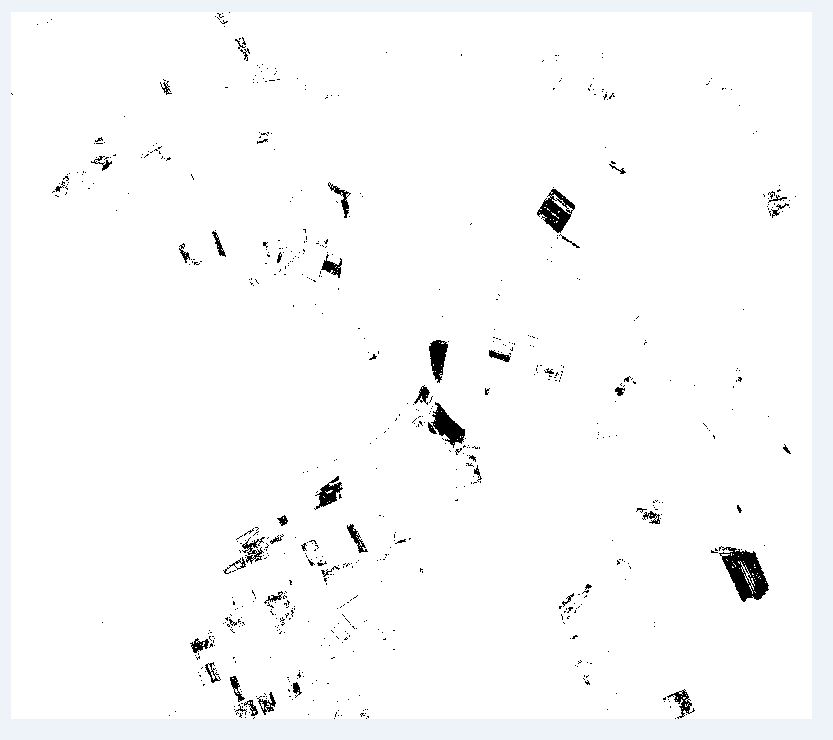

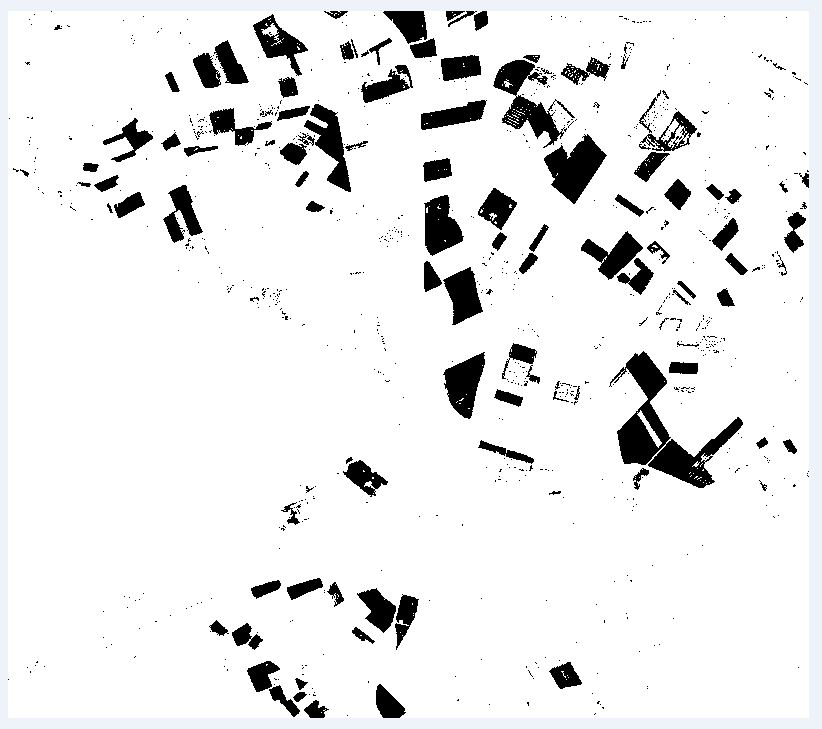

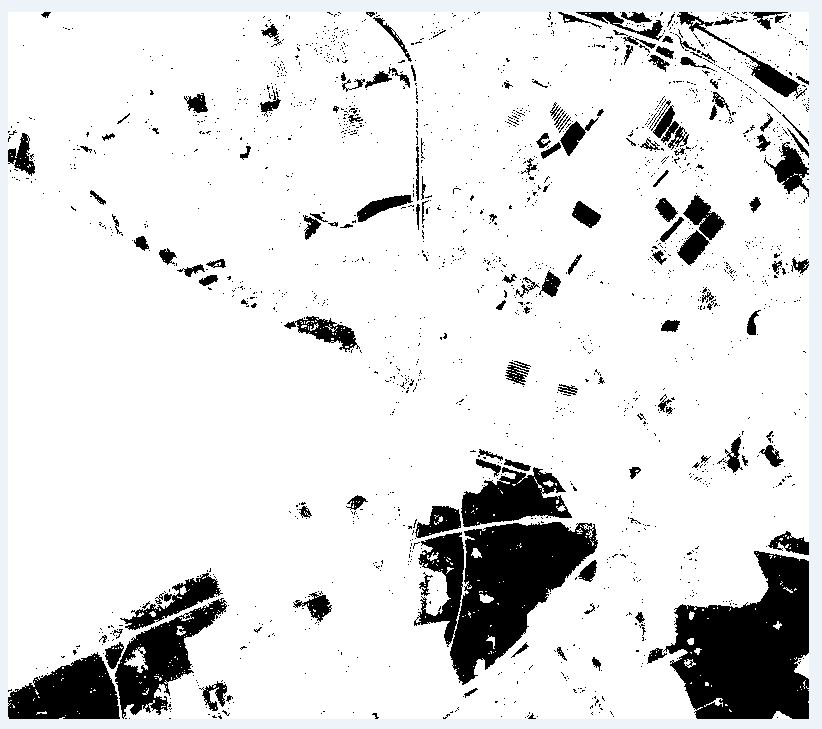

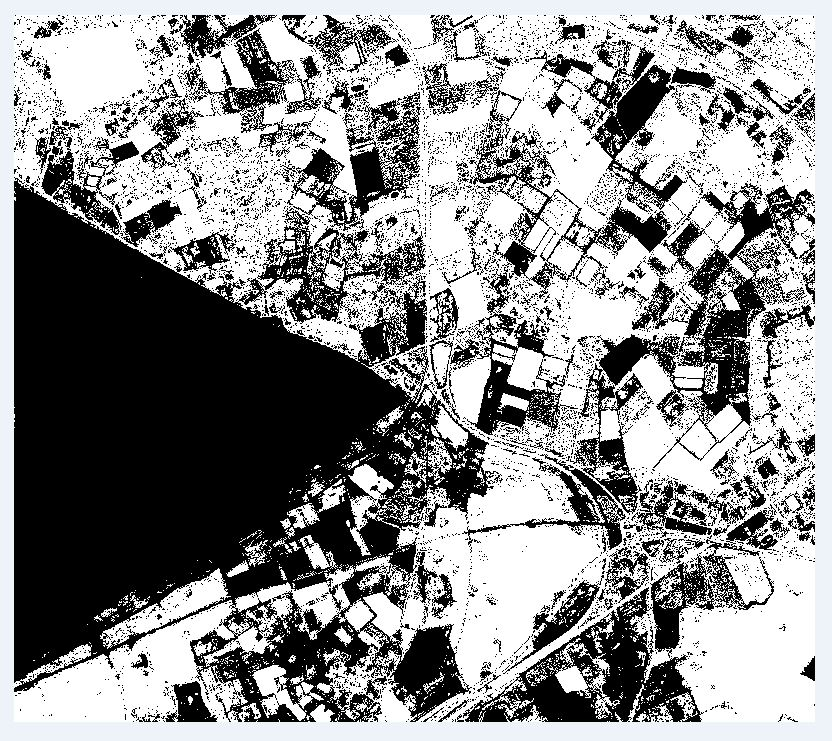

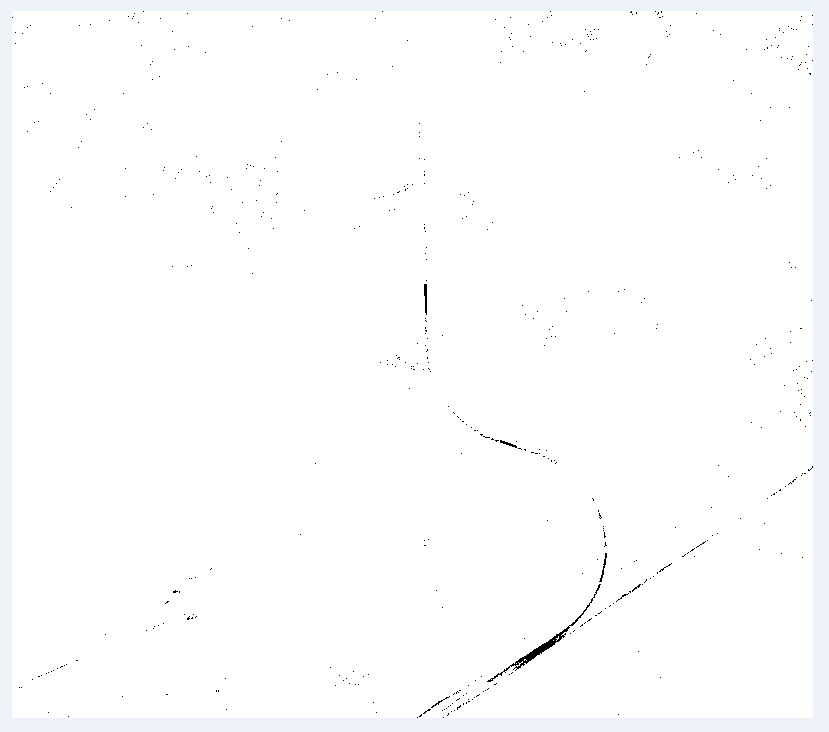

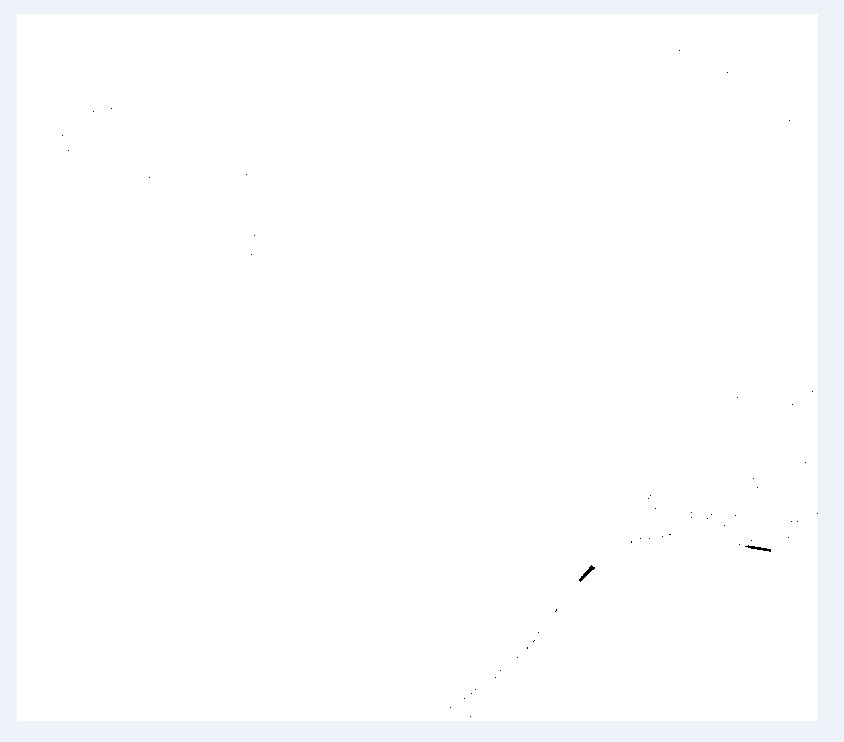

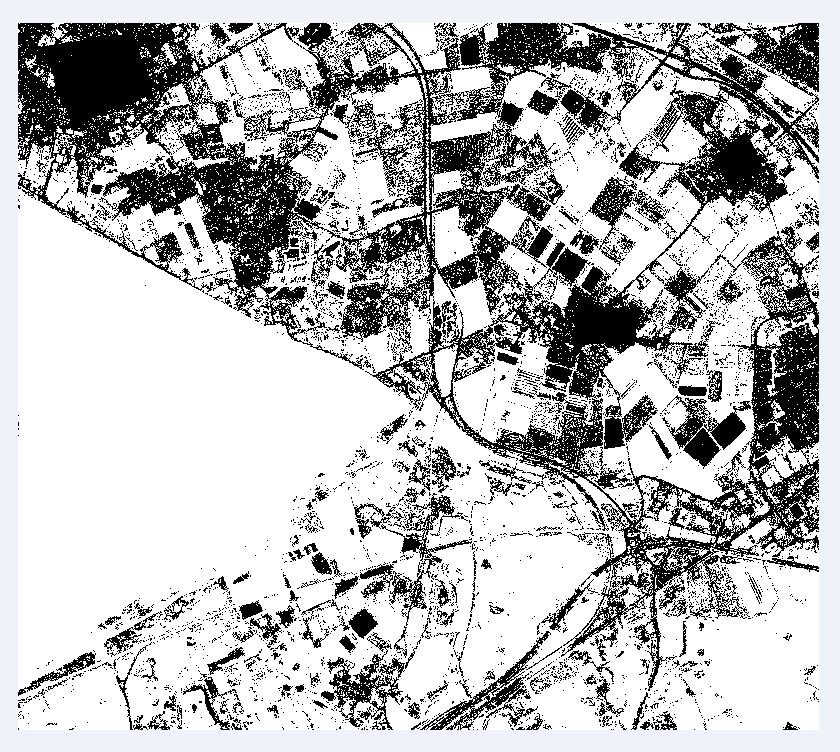

In [218]:
a= Image(filename='Dirt.jpg', width="300")
b= Image(filename='Farm.jpg', width="300") 
c= Image(filename='Forest.jpg', width="300")
d= Image(filename='Mine.jpg', width="300")
e= Image(filename='Railway.jpg', width="300")
f= Image(filename='Road.jpg', width="300")
g= Image(filename='Buildings.jpg', width="300")

display(a,b,c,d,e,f,g)

#                             End of the first part/ Image classification using Sentinel2 data

#  Part 2: 
# Image classification using EuroSAT data

# Load and Inspect Data

In [219]:
# folder containing eurosat rgb images
DATA_DIRECTORY = '05_eurosat_rgb'

# each subfolder corresponds to a class
label_names = os.listdir(DATA_DIRECTORY)
print('Labels: {}'.format(label_names))

Labels: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [220]:
# get number of images per label
c = 0
for label in label_names:
    files = os.listdir(DATA_DIRECTORY + '/' + label)
    n_files = len(files)
    c += n_files
    print('{}: {}'.format(label, n_files))
print('\nTotal number of images: {}'.format(c))

AnnualCrop: 1000
Forest: 1000
HerbaceousVegetation: 1000
Highway: 1000
Industrial: 1000
Pasture: 1000
PermanentCrop: 1000
Residential: 1000
River: 1000
SeaLake: 1000

Total number of images: 10000


# Visualize the Data

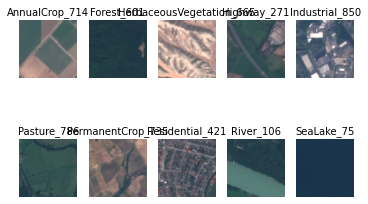

In [221]:
# plot some examples
np.random.seed(0)
fig, axs = plt.subplots(2, 5)

# label directories
DATA_DIRECTORY = '05_eurosat_rgb'
label_dirs = [DATA_DIRECTORY + '/' + label + '/' for label in label_names]

for label_dir, ax in zip(label_dirs, axs.flatten()):

    # choose random image for each class
    fnames = os.listdir(label_dir)
    fname = np.random.choice(fnames)

    # read image
    img = mpimg.imread(label_dir + fname)
    
    # show
    ax.imshow(img)   
    
    # title
    ax.set_title(fname[:-4], fontsize=10)
    
    # turn off axis
    ax.set_axis_off()

# Preprocess the Data

## Create numpy arrays from JPG images

In [222]:
# label <-> integer
labels = ['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 
          'Industrial', 'Residential', 'PermanentCrop', 'Pasture'] 
label_dict = dict(zip(labels, np.arange(len(labels), dtype=int)))
reverse_label_dict = dict(map(reversed, label_dict.items()))

def create_X_y(DATA_DIRECTORY):
    """
    DATA_DIRECTORY: string, either "05_eurosat_rgb" or "05_eurosat_all"
    """
    
    # label directories
    label_names = os.listdir(DATA_DIRECTORY)
    label_dirs = [DATA_DIRECTORY + '/' + label + '/' for label in label_names]

    # containers for images and labels
    X = []
    y = []

    for label_dir in label_dirs:
        
        print(label_dir)
        
        fnames = os.listdir(label_dir)
        
        for fname in fnames:

            # extract label from file name
            label = fname.split('_')[0]
            yi = label_dict[label]
            y.append(yi)

            # read image
            if DATA_DIRECTORY == '05_eurosat_rgb':
                Xi = mpimg.imread(label_dir + fname)
            elif DATA_DIRECTORY == '05_eurosat_all':
                Xi = rasterio.open(label_dir + fname).read()
                Xi = np.moveaxis(Xi, 0, -1)
                # Xi = tiff.imread(label_dir + fname)
                
            X.append(Xi)

    X = np.asarray(X)
    y = np.asarray(y)
    # y = tf.keras.utils.to_categorical(y)
    
    return X, y
    
X, y = create_X_y('05_eurosat_rgb')

05_eurosat_rgb/AnnualCrop/
05_eurosat_rgb/Forest/
05_eurosat_rgb/HerbaceousVegetation/
05_eurosat_rgb/Highway/
05_eurosat_rgb/Industrial/
05_eurosat_rgb/Pasture/
05_eurosat_rgb/PermanentCrop/
05_eurosat_rgb/Residential/
05_eurosat_rgb/River/
05_eurosat_rgb/SeaLake/


In [223]:
print(X.shape, X.dtype, X.min(), X.max())
print(y.shape, y.dtype)

(10000, 64, 64, 3) uint8 8 255
(10000,) int32


In [224]:
y

array([3, 3, 3, ..., 4, 4, 4])

In [225]:
print(X[0, :, :, 0])
print(np.unique(y, return_counts=True))

[[149 149 148 ... 102 104 103]
 [149 149 148 ... 102 104 103]
 [143 142 146 ... 102 102 103]
 ...
 [144 141 137 ... 103 100 101]
 [132 132 127 ... 105 105 107]
 [124 122 120 ... 106 106 107]]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
      dtype=int64))


## Split into Train/Test samples

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(np.unique(y_train, return_counts=True)[1]/len(y_train))
print(np.unique(y_test, return_counts=True)[1]/len(y_test))

(8000, 64, 64, 3) (8000,) (2000, 64, 64, 3) (2000,)
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


## Rescale Images

In [227]:
# rescale
X_train, X_test = X_train/255., X_test/255.
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())
X_test.dtype

0.03137254901960784 1.0 0.07058823529411765 1.0


dtype('float64')

# Train a shallow MLP (1,574,282 params) [~45%] [40s]

In [228]:
# keep track of loss curves (training histories)
ths = {}

In [229]:
# build tf.keras.Sequential model by stacking layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
  tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# print summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1572992   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,574,282
Trainable params: 1,574,282
Non-trainable params: 0
_________________________________________________________________


In [230]:
%%time

# choose loss function (cross-entropy), optimizer and score metric (accuracy), compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# fit
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
ths['shallow MLP'] = history

Epoch 1/50
250/250 [==============================] - 4s 12ms/step - loss: 2.0645 - accuracy: 0.2418 - val_loss: 1.8596 - val_accuracy: 0.2615
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 1.8029 - accuracy: 0.2959 - val_loss: 1.7843 - val_accuracy: 0.3170
Epoch 3/50
250/250 [==============================] - 2s 10ms/step - loss: 1.7297 - accuracy: 0.3334 - val_loss: 1.7199 - val_accuracy: 0.3075
Epoch 4/50
250/250 [==============================] - 3s 10ms/step - loss: 1.6983 - accuracy: 0.3436 - val_loss: 1.7734 - val_accuracy: 0.3165
Epoch 5/50
250/250 [==============================] - 3s 10ms/step - loss: 1.6606 - accuracy: 0.3580 - val_loss: 1.6797 - val_accuracy: 0.4030
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 1.6234 - accuracy: 0.3905 - val_loss: 1.7442 - val_accuracy: 0.3205
Epoch 7/50
250/250 [==============================] - 3s 10ms/step - loss: 1.6206 - accuracy: 0.3959 - val_loss: 1.7348 - val_accuracy: 0.3860

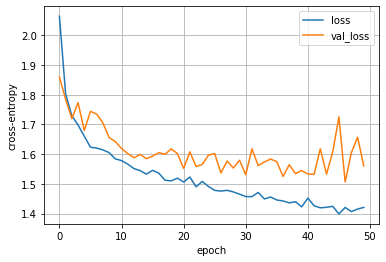

In [232]:
# plot learning history
fig, ax = plt.subplots()

# ax.plot(history.history['acc'], label='accuracy')  # if tf version 1
ax.plot(history.history['loss'], label='loss')
# ax.plot(history.history['val_acc'], label='val_accuracy')  # if tf version 1
ax.plot(history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('cross-entropy')
# ax.set_ylim([0.5, 1])
ax.legend()
ax.grid()

In [233]:
# evaluate
model.evaluate(X_test, y_test, verbose=2)

63/63 - 0s - loss: 1.5605 - accuracy: 0.4465


[1.5604579448699951, 0.4465000033378601]

# Train a "2xCP" CNN (809,322 params) [~77%] [33s]

In [234]:
# sequential model
model = tf.keras.models.Sequential()

# add layers
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# flatten last convolution, add dense layer for aggregation, add output layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10))

# summary of entire model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [235]:
%%time

# choose optimizer, loss function, score metric, compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# fit
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))
ths['2xCP CNN'] = history

Epoch 1/15
250/250 [==============================] - 13s 50ms/step - loss: 1.4891 - accuracy: 0.4154 - val_loss: 1.2507 - val_accuracy: 0.5155
Epoch 2/15
250/250 [==============================] - 12s 47ms/step - loss: 1.0821 - accuracy: 0.5960 - val_loss: 1.0018 - val_accuracy: 0.6310
Epoch 3/15
250/250 [==============================] - 12s 48ms/step - loss: 0.8759 - accuracy: 0.6839 - val_loss: 1.0766 - val_accuracy: 0.6015
Epoch 4/15
250/250 [==============================] - 12s 47ms/step - loss: 0.7426 - accuracy: 0.7365 - val_loss: 0.8480 - val_accuracy: 0.6870402 - accu - ETA: 0s - loss: 0.7403 - accuracy: 
Epoch 5/15
250/250 [==============================] - 12s 47ms/step - loss: 0.6430 - accuracy: 0.7740 - val_loss: 0.6695 - val_accuracy: 0.7640
Epoch 6/15
250/250 [==============================] - 12s 48ms/step - loss: 0.5969 - accuracy: 0.7883 - val_loss: 0.7361 - val_accuracy: 0.7250
Epoch 7/15
250/250 [==============================] - 12s 47ms/step - loss: 0.5424 - acc

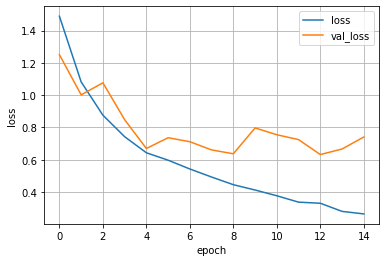

In [236]:
# plot learning history
fig, ax = plt.subplots()

# ax.plot(history.history['acc'], label='accuracy')  # if tf version 1
ax.plot(history.history['loss'], label='loss')
# ax.plot(history.history['val_acc'], label='val_accuracy')  # if tf version 1
ax.plot(history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
# ax.set_ylim([0.5, 1])
ax.legend()
ax.grid()

In [237]:
# evaluate
evaluation = model.evaluate(X_test, y_test, verbose=2)

63/63 - 1s - loss: 0.7405 - accuracy: 0.7785


# Train a "4xCP" CNN (66,330 params) [~80%] [75s]

In [238]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

# summary of entire model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

In [239]:
# choose optimizer, loss function, score metric, compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [240]:
%%time

# fit
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
ths['4xCP CNN'] = history

Epoch 1/50
250/250 [==============================] - 9s 35ms/step - loss: 1.6959 - accuracy: 0.3300 - val_loss: 1.3439 - val_accuracy: 0.4355
Epoch 2/50
250/250 [==============================] - 8s 33ms/step - loss: 1.2753 - accuracy: 0.4936 - val_loss: 1.0874 - val_accuracy: 0.5985
Epoch 3/50
250/250 [==============================] - 8s 33ms/step - loss: 1.0453 - accuracy: 0.6127 - val_loss: 0.9048 - val_accuracy: 0.6535
Epoch 4/50
250/250 [==============================] - 9s 34ms/step - loss: 0.9316 - accuracy: 0.6534 - val_loss: 0.8971 - val_accuracy: 0.6670
Epoch 5/50
250/250 [==============================] - 9s 34ms/step - loss: 0.8462 - accuracy: 0.6862 - val_loss: 0.8318 - val_accuracy: 0.6995
Epoch 6/50
250/250 [==============================] - 9s 35ms/step - loss: 0.7931 - accuracy: 0.7065 - val_loss: 0.8113 - val_accuracy: 0.7030
Epoch 7/50
250/250 [==============================] - 9s 34ms/step - loss: 0.7625 - accuracy: 0.7206 - val_loss: 0.7375 - val_accuracy: 0.7320

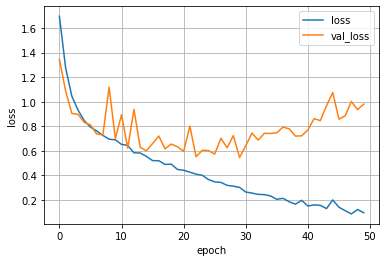

In [241]:
# plot learning history
fig, ax = plt.subplots()

# ax.plot(history.history['acc'], label='accuracy')  # if tf version 1
ax.plot(history.history['loss'], label='loss')
# ax.plot(history.history['val_acc'], label='val_accuracy')  # if tf version 1
ax.plot(history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
# ax.set_ylim([0.5, 1])
ax.legend()
ax.grid()

In [242]:
# evaluate
evaluation = model.evaluate(X_test, y_test, verbose=2)

63/63 - 0s - loss: 0.9805 - accuracy: 0.7990


# Train a "2xCCP" CNN (3,233,562 params) [~80%] [63s]

In [243]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10)
])

# summary of entire model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)             

In [244]:
# choose optimizer, loss function, score metric, compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [245]:
%%time

# fit
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))
ths['2xCCP CNN'] = history

Epoch 1/15
250/250 [==============================] - 37s 145ms/step - loss: 1.4887 - accuracy: 0.4131 - val_loss: 1.1563 - val_accuracy: 0.5595
Epoch 2/15
250/250 [==============================] - 36s 144ms/step - loss: 1.0105 - accuracy: 0.6290 - val_loss: 0.8584 - val_accuracy: 0.6795
Epoch 3/15
250/250 [==============================] - 36s 144ms/step - loss: 0.7433 - accuracy: 0.7297 - val_loss: 0.7289 - val_accuracy: 0.7390
Epoch 4/15
250/250 [==============================] - 36s 145ms/step - loss: 0.6715 - accuracy: 0.7615 - val_loss: 0.7562 - val_accuracy: 0.7305
Epoch 5/15
250/250 [==============================] - 36s 145ms/step - loss: 0.5141 - accuracy: 0.8194 - val_loss: 0.6765 - val_accuracy: 0.7605
Epoch 6/15
250/250 [==============================] - 36s 145ms/step - loss: 0.4270 - accuracy: 0.8494 - val_loss: 0.6102 - val_accuracy: 0.7885
Epoch 7/15
250/250 [==============================] - 36s 146ms/step - loss: 0.3643 - accuracy: 0.8715 - val_loss: 0.6847 - val_ac

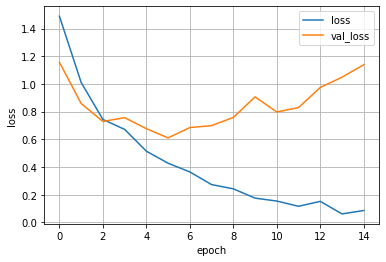

In [246]:
# plot learning history
fig, ax = plt.subplots()

# ax.plot(history.history['acc'], label='accuracy')  # if tf version 1
ax.plot(history.history['loss'], label='loss')
# ax.plot(history.history['val_acc'], label='val_accuracy')  # if tf version 1
ax.plot(history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
# ax.set_ylim([0.5, 1])
ax.legend()
ax.grid()

In [247]:
# evaluate
evaluation = model.evaluate(X_test, y_test, verbose=2)

63/63 - 1s - loss: 1.1387 - accuracy: 0.7515


# Reduce Complexity of "2xCCP" CNN (3,235,610 params) [81%] [120s]

In [248]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.6),
    tf.keras.layers.Dense(10)
])

# summary of entire model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)       

In [249]:
# choose optimizer, loss function, score metric, compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [250]:
%%time

# fit
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))
ths['2xCCP regularized CNN'] = history

Epoch 1/30
250/250 [==============================] - 40s 158ms/step - loss: 1.4944 - accuracy: 0.4514 - val_loss: 1.8816 - val_accuracy: 0.2475
Epoch 2/30
250/250 [==============================] - 37s 147ms/step - loss: 1.0571 - accuracy: 0.6217 - val_loss: 1.1996 - val_accuracy: 0.5035
Epoch 3/30
250/250 [==============================] - 34s 136ms/step - loss: 0.9052 - accuracy: 0.6819 - val_loss: 0.7335 - val_accuracy: 0.7350
Epoch 4/30
250/250 [==============================] - 34s 137ms/step - loss: 0.7802 - accuracy: 0.7283 - val_loss: 0.7477 - val_accuracy: 0.7365
Epoch 5/30
250/250 [==============================] - 34s 137ms/step - loss: 0.7490 - accuracy: 0.7366 - val_loss: 1.2855 - val_accuracy: 0.5800
Epoch 6/30
250/250 [==============================] - 34s 136ms/step - loss: 0.6699 - accuracy: 0.7696 - val_loss: 0.8632 - val_accuracy: 0.7250
Epoch 7/30
250/250 [==============================] - 34s 136ms/step - loss: 0.6058 - accuracy: 0.7910 - val_loss: 1.4494 - val_ac

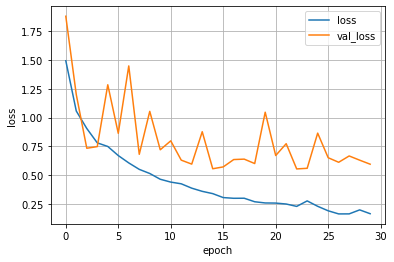

In [251]:
# plot learning history
fig, ax = plt.subplots()

# ax.plot(history.history['acc'], label='accuracy')  # if tf version 1
ax.plot(history.history['loss'], label='loss')
# ax.plot(history.history['val_acc'], label='val_accuracy')  # if tf version 1
ax.plot(history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
# ax.set_ylim([0.5, 1])
ax.legend()
ax.grid()

In [252]:
# evaluate
evaluation = model.evaluate(X_test, y_test, verbose=2)

63/63 - 1s - loss: 0.5947 - accuracy: 0.8385


# Summary of Results

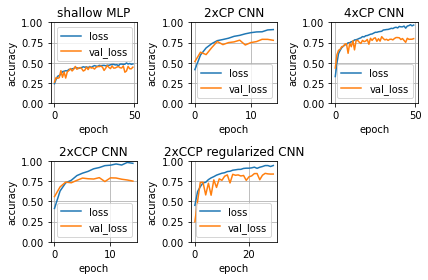

In [253]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

for ax, (name, hist) in zip(axs, ths.items()):

    ax.plot(hist.history['accuracy'], label='loss')
    # ax.plot(history.history['val_acc'], label='val_accuracy')  # if tf version 1
    ax.plot(hist.history['val_accuracy'], label='val_loss')

    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_ylim([0, 1])
    ax.set_title(name)
    ax.legend()
    ax.grid()
    
axs[-1].set_axis_off()
fig.tight_layout()

# How can we improve the model(s) further?

- use all the available training data from EuroSAT (we are only using 1000 images per class (10.000 in total), but there are 27.000 images in the EuroSAT archive)
- use all 13 bands to feed to the CNN (we are only using RGB)
- Use more complex CNN architectures in conjunction with regularization

# Storing a (Trained) TF Model

In [254]:
model.save('05_trained_CNN', save_format='tf')

INFO:tensorflow:Assets written to: 05_trained_CNN\assets


# Loading a (Trained) TF Model

In [255]:
loaded_model = tf.keras.models.load_model('05_trained_CNN')

In [256]:
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)       

In [257]:
# evaluate
evaluation = model.evaluate(X_test, y_test, verbose=2)

63/63 - 1s - loss: 0.5947 - accuracy: 0.8385


# Show Predictions

In [258]:
# show prediction
# For each example the model returns a vector of "logits" or "log-odds" scores, one for each class
np.random.seed(1)

In [259]:
idx = np.random.randint(len(X_test), size=20)
X_test.dtype

dtype('float64')

In [260]:
y_pred_logit = model(X_test.astype('float32')[idx]).numpy()

In [261]:
# The tf.nn.softmax function converts logits to probabilities for each class: 
y_pred = tf.nn.softmax(y_pred_logit).numpy()
print(y_pred.argmax(axis=1))
print(y_test[idx])

[7 9 7 5 0 4 5 3 9 5 3 0 5 0 8 2 8 1 7 4]
[7 9 7 7 0 4 8 3 9 5 3 0 5 1 8 2 8 1 7 4]


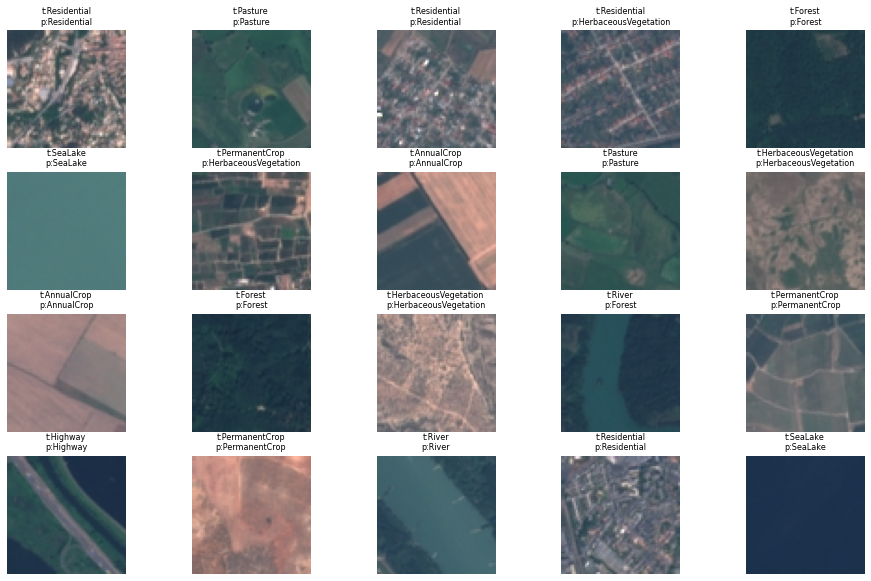

In [262]:
# plot images with true/predicted labels
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for X_test_i, y_test_i, y_pred_i, ax in zip(X_test[idx], y_test[idx], y_pred, axs.flatten()):
    ax.imshow(X_test_i)
    true_label = reverse_label_dict[y_test_i]
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('t:{}\np:{}'.format(true_label, pred_label), fontsize=8)
    ax.set_axis_off()

# Use the CNN to Predict on Elsdorf Image

We can use this traind model to classify other images like Elsdorf sentinel2 data. I use the RGB color image I produced in the first section with a color scale of 275.

**The reason we use 0.275 rather than 0.3558 is because the EuroSAT dataset used in Day 5 was rescaled to this value (0.275)!**

In [263]:
# load the sentinel scene from Elsdorf
sentinel_fp = 'Elsdorf_sentinel_2019_rgb_8bit_275.jpg'
img = mpimg.imread(sentinel_fp) 

We need to apply the same 0-1 rescaling as with the EuroSAT data

In [264]:
# rescale
img = img / 255.
print(img.dtype)

float64


And we need 64\*64 pixel tiles (same size as EuroSAT) for passing to the trained CNN. We'll tile our full dataset in the below nested for loop.

In [265]:
# set the window size (64 * 64)
windowSize = 64
# create an empty tile array
tiles = []

In [266]:
# loop over rows and columns in full array, striding by the window size
for row in range(0, img.shape[0], windowSize):
    for col in range(0, img.shape[1], windowSize):
        
        # pull out the tile
        img_tile = img[row : row + windowSize, col : col + windowSize, :]
        
        # check if the tile is actually 64*64, and skip if not
        if img_tile.shape[0] == windowSize and img_tile.shape[1] == windowSize:
            
            # add the tile to the list
            tiles.append(img_tile)

# recast tile list as numpy array
tiles = np.asarray(tiles)

Now the data is prepared just like EuroSAT and we can pass some tiles through the CNN and get predictions!

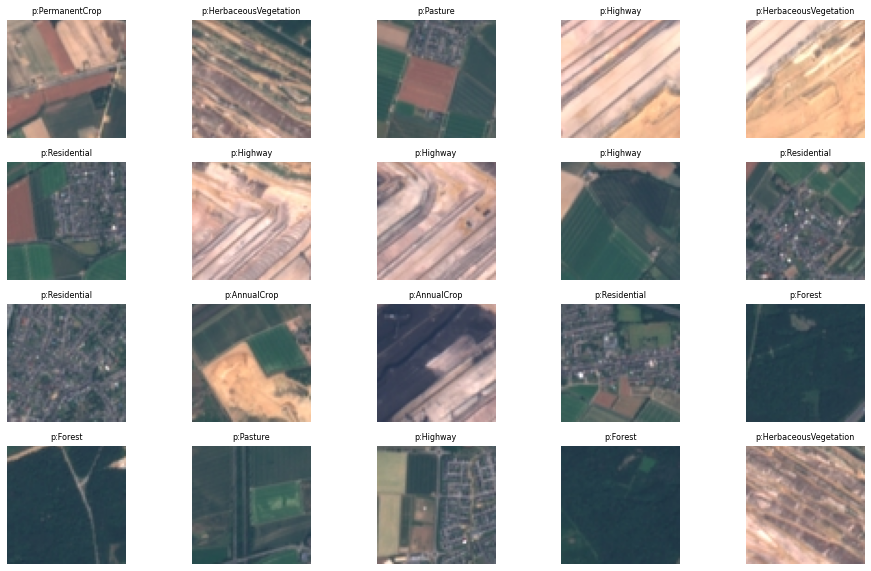

In [267]:
# predict on 20 random tiles using the trained CNN model from above
idx = np.random.randint(len(tiles), size=20)

y_pred_logit_tiles = model(tiles[idx].astype('float32')).numpy()
y_pred_tiles = tf.nn.softmax(y_pred_logit_tiles).numpy()

# plot the results to visualize
fig, axs = plt.subplots(4, 5, figsize=(16, 10))
for tile_i, y_pred_i, ax in zip(tiles[idx], y_pred_tiles, axs.flatten()):
    ax.imshow(tile_i)
    pred_label = reverse_label_dict[y_pred_i.argmax()]
    ax.set_title('p:{}'.format(pred_label), fontsize=8)
    ax.set_axis_off()


It seems that the predicted model from the EuroSAT can not perfectly use to classify Elsdorf Sentinel 2 image. Maybe the reasone is that Mining activity in the area is significant. There are so many roads constructed in the mining area which is detected by the model as Highway which seems ok but also some parts are classified as vegetation which can not be true. Overall I am myself satisfied with the classification result both from Random Forest in part 1 and from CNN model from part 2.